In [1]:
import torch, torchaudio, torchvision.transforms as transforms, matplotlib.pyplot as plt, torch.nn as nn, torch.optim as optim, numpy as np
from torch.utils.data import DataLoader, TensorDataset, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import sys
sys.path.append("../")
from ad_utils import *

import warnings
warnings.filterwarnings('ignore')

cuda0 = torch.device("cuda:0")
cuda1 = torch.device("cuda:1")
device = cuda1
print(torch.cuda.get_device_name(device) if torch.cuda.is_available() else "No GPU available")

data = np.load("../../hvcm/RFQ.npy", allow_pickle=True)
label = np.load("../../hvcm/RFQ_labels.npy", allow_pickle=True)
label = label[:, 1]  # Assuming the second column is the label
label = (label == "Fault").astype(int)  # Convert to binary labels
print(data.shape, label.shape)

# Data preprocessing
scaler = StandardScaler()
data = scaler.fit_transform(data.reshape(-1, data.shape[-1])).reshape(data.shape)

normal_data = data[label == 0]
faulty_data = data[label == 1]

normal_label = label[label == 0]
faulty_label = label[label == 1]

X_train_normal, X_test_normal, y_train_normal, y_test_normal = train_test_split(normal_data, normal_label, test_size=0.2, random_state=42, shuffle=True)
X_train_faulty, X_test_faulty, y_train_faulty, y_test_faulty = train_test_split(faulty_data, faulty_label, test_size=0.2, random_state=42, shuffle=True)

NVIDIA A30
(872, 4500, 14) (872,)


# Anomaly Aware GAN

In [2]:
class AnomalyAwareBiGAN(nn.Module):
    def __init__(self, latent_dim=64, channels=14, seq_len=4500):
        super(AnomalyAwareBiGAN, self).__init__()
        self.generator = BiGANGenerator(latent_dim, channels, seq_len)
        self.encoder = Encoder(channels, seq_len, latent_dim)
        self.discriminator = BiGANDiscriminator(channels, seq_len, latent_dim)
        
        # Additional anomaly-aware components
        self.anomaly_discriminator = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
        
    def compute_anomaly_aware_loss(self, real_data, fake_data, encoded_z, random_z):
        # Standard BiGAN losses
        real_validity = self.discriminator(real_data, encoded_z)
        fake_validity = self.discriminator(fake_data, random_z)
        
        # Anomaly-aware loss: encourage encoded_z to be distinguishable from random_z
        anomaly_real = self.anomaly_discriminator(encoded_z)
        anomaly_fake = self.anomaly_discriminator(random_z)
        
        # Additional reconstruction consistency loss
        reconstructed = self.generator(encoded_z)
        reconstruction_loss = torch.mean((real_data - reconstructed) ** 2)
        
        return {
            'bigan_loss': torch.mean(real_validity) - torch.mean(fake_validity),
            'anomaly_loss': torch.mean(anomaly_real) - torch.mean(anomaly_fake),
            'reconstruction_loss': reconstruction_loss
        }
    
# Data preprocessing with normalization
def preprocess_data(data, scaler=None, fit_scaler=True):
    """
    Preprocess data with normalization
    Returns normalized data and scaler for denormalization
    """
    original_shape = data.shape
    data_reshaped = data.reshape(-1, data.shape[-1])
    
    if scaler is None:
        scaler = StandardScaler()
    
    if fit_scaler:
        normalized_data = scaler.fit_transform(data_reshaped)
    else:
        normalized_data = scaler.transform(data_reshaped)
    
    return normalized_data.reshape(original_shape), scaler

def denormalize_data(data, scaler):
    """
    Denormalize data back to original scale
    """
    original_shape = data.shape
    data_reshaped = data.reshape(-1, data.shape[-1])
    denormalized_data = scaler.inverse_transform(data_reshaped)
    return denormalized_data.reshape(original_shape)

# Encoder for BiGAN (adapted for multivariate time series)
class Encoder(nn.Module):
    def __init__(self, channels=14, seq_len=4500, latent_dim=100):
        super(Encoder, self).__init__()
        
        # Calculate feature map sizes after convolutions
        # After conv1: seq_len/2, After conv2: seq_len/4, After conv3: seq_len/8, After conv4: seq_len/16
        final_seq_len = seq_len // 16  # ~281
        
        self.conv_layers = nn.Sequential(
            # First conv block
            nn.Conv1d(channels, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Second conv block  
            nn.Conv1d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Third conv block
            nn.Conv1d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Fourth conv block
            nn.Conv1d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
        )
        
        # Calculate the flattened size
        self.flattened_size = 512 * final_seq_len
        
        # Final layers to latent space
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.flattened_size, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, latent_dim)
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Generator for BiGAN (adapted for multivariate time series)
class BiGANGenerator(nn.Module):
    def __init__(self, latent_dim=100, channels=14, seq_len=4500):
        super(BiGANGenerator, self).__init__()
        self.latent_dim = latent_dim
        self.channels = channels
        self.seq_len = seq_len
        
        # Start with a smaller sequence length and upsample
        self.init_seq_len = seq_len // 16  # ~281
        
        self.fc_layer = nn.Sequential(
            nn.Linear(latent_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512 * self.init_seq_len),
            nn.BatchNorm1d(512 * self.init_seq_len),
            nn.ReLU(inplace=True)
        )
        
        self.conv_blocks = nn.Sequential(
            # First deconv block
            nn.ConvTranspose1d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            
            # Second deconv block
            nn.ConvTranspose1d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            
            # Third deconv block
            nn.ConvTranspose1d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            
            # Final deconv block
            nn.ConvTranspose1d(64, channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        out = self.fc_layer(z)
        out = out.view(out.shape[0], 512, self.init_seq_len)
        out = self.conv_blocks(out)
        
        # Ensure exact sequence length through interpolation if needed
        if out.size(2) != self.seq_len:
            out = nn.functional.interpolate(out, size=self.seq_len, mode='linear', align_corners=False)
        
        return out

# Joint Discriminator for BiGAN (takes both data and latent code)
class BiGANDiscriminator(nn.Module):
    def __init__(self, channels=14, seq_len=4500, latent_dim=100):
        super(BiGANDiscriminator, self).__init__()
        
        # Data pathway - similar to your original discriminator
        final_seq_len = seq_len // 16  # After 4 conv layers with stride 2
        
        self.data_path = nn.Sequential(
            nn.Conv1d(channels, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv1d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv1d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv1d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Flatten()
        )
        
        self.data_feature_size = 512 * final_seq_len
        
        # Latent pathway
        self.latent_path = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        # Joint discriminator
        self.joint_discriminator = nn.Sequential(
            nn.Linear(self.data_feature_size + 512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x, z):
        data_features = self.data_path(x)
        latent_features = self.latent_path(z)
        joint_features = torch.cat([data_features, latent_features], dim=1)
        return self.joint_discriminator(joint_features)

# BiGAN Model wrapper
class BiGAN(nn.Module):
    def __init__(self, latent_dim=100, channels=14, seq_len=4500):
        super(BiGAN, self).__init__()
        self.generator = BiGANGenerator(latent_dim, channels, seq_len)
        self.encoder = Encoder(channels, seq_len, latent_dim)
        self.discriminator = BiGANDiscriminator(channels, seq_len, latent_dim)
        self.latent_dim = latent_dim
        
    def forward(self, x=None, z=None, mode='encode'):
        if mode == 'encode':
            return self.encoder(x)
        elif mode == 'generate':
            return self.generator(z)
        elif mode == 'discriminate':
            return self.discriminator(x, z)

# Anomaly detection using reconstruction and encoding errors
def compute_anomaly_scores(bigan, data_loader, device, data_scaler=None):
    """
    Compute anomaly scores using both reconstruction and encoding errors
    """
    bigan.eval()
    anomaly_scores = []
    
    with torch.no_grad():
        for batch_data, _ in data_loader:
            batch_data = batch_data.to(device)
            
            # Encode real data
            encoded_z = bigan.encoder(batch_data)
            
            # Reconstruct from encoded latent
            reconstructed_x = bigan.generator(encoded_z)
            
            # Reconstruction error
            recon_error = torch.mean((batch_data - reconstructed_x) ** 2, dim=(1, 2))
            
            # Encoding consistency error
            random_z = torch.randn_like(encoded_z)
            generated_x = bigan.generator(random_z)
            encoded_generated = bigan.encoder(generated_x)
            encoding_error = torch.mean((random_z - encoded_generated) ** 2, dim=1)
            
            # Combined anomaly score (weighted combination)
            combined_score = 0.7 * recon_error + 0.3 * encoding_error
            anomaly_scores.extend(combined_score.cpu().numpy())
    
    return np.array(anomaly_scores)

class FewShot1DDataset(Dataset):
    def __init__(self, data):
        # Convert from (samples, seq_len, channels) to (samples, channels, seq_len) for Conv1d
        self.data = torch.tensor(data.transpose(0, 2, 1), dtype=torch.float32)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], 0  # Return dummy label

In [3]:
# ========================================
# SPECIALIZED TRAINING FOR NORMAL DATA GENERATION
# ========================================

def train_bigan_for_normal_data_generation(normal_data, device, epochs=100, batch_size=16, 
                                         latent_dim=64, save_interval=20, verbose=True):
    """
    Specialized training function for BiGAN focused on generating high-quality normal data
    for anomaly detection applications.
    """
    print("🚀 Training BiGAN specifically for Normal Data Generation")
    print("=" * 60)
    
    # Preprocessing with normalization
    normal_data_normalized, data_scaler = preprocess_data(normal_data, fit_scaler=True)
    
    # Data loading with proper augmentation
    dataset = FewShot1DDataset(normal_data_normalized)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    
    # Initialize BiGAN with optimized parameters for normal data
    bigan = AnomalyAwareBiGAN(latent_dim=latent_dim, channels=14, seq_len=4500).to(device)
    
    # Optimizers with different learning rates for better stability
    optimizer_G = optim.Adam(bigan.generator.parameters(), lr=0.0001, betas=(0.5, 0.999), weight_decay=1e-5)
    optimizer_E = optim.Adam(bigan.encoder.parameters(), lr=0.0001, betas=(0.5, 0.999), weight_decay=1e-5)
    optimizer_D = optim.Adam(bigan.discriminator.parameters(), lr=0.00005, betas=(0.5, 0.999), weight_decay=1e-5)  # Slower D
    optimizer_A = optim.Adam(bigan.anomaly_discriminator.parameters(), lr=0.00005, betas=(0.5, 0.999), weight_decay=1e-5)
    
    # Learning rate schedulers
    scheduler_G = optim.lr_scheduler.ReduceLROnPlateau(optimizer_G, mode='min', factor=0.8, patience=15, verbose=verbose)
    scheduler_E = optim.lr_scheduler.ReduceLROnPlateau(optimizer_E, mode='min', factor=0.8, patience=15, verbose=verbose)
    scheduler_D = optim.lr_scheduler.ReduceLROnPlateau(optimizer_D, mode='min', factor=0.8, patience=15, verbose=verbose)
    
    # Loss function with label smoothing
    adversarial_loss = nn.BCELoss()
    reconstruction_loss = nn.MSELoss()
    
    # Training history
    training_history = {
        'g_losses': [], 'e_losses': [], 'd_losses': [], 'a_losses': [], 'recon_losses': []
    }
    
    # Training loop optimized for normal data generation
    print(f"📊 Training on {len(dataset)} normal samples for {epochs} epochs...")
    
    for epoch in range(epochs):
        epoch_losses = {'g': 0, 'e': 0, 'd': 0, 'a': 0, 'recon': 0}
        
        for i, (real_samples, _) in enumerate(dataloader):
            real_samples = real_samples.to(device)
            batch_size_current = real_samples.size(0)
            
            # Labels with smoothing for better stability
            real_labels = torch.ones(batch_size_current, 1, device=device) * 0.9
            fake_labels = torch.zeros(batch_size_current, 1, device=device) + 0.1
            
            # Generate random latent vectors
            z = torch.randn(batch_size_current, latent_dim, device=device)
            
            # ---------------------
            #  Train Discriminator (Less Frequently)
            # ---------------------
            if i % 2 == 0:  # Train discriminator every other iteration
                optimizer_D.zero_grad()
                
                # Real data with encoded latent
                encoded_z = bigan.encoder(real_samples)
                real_validity = bigan.discriminator(real_samples, encoded_z)
                d_real_loss = adversarial_loss(real_validity, real_labels)
                
                # Fake data with random latent
                fake_samples = bigan.generator(z)
                fake_validity = bigan.discriminator(fake_samples.detach(), z)
                d_fake_loss = adversarial_loss(fake_validity, fake_labels)
                
                d_loss = (d_real_loss + d_fake_loss) / 2
                d_loss.backward()
                torch.nn.utils.clip_grad_norm_(bigan.discriminator.parameters(), max_norm=0.5)
                optimizer_D.step()
                
                epoch_losses['d'] += d_loss.item()
            
            # ---------------------
            #  Train Anomaly Discriminator
            # ---------------------
            if i % 3 == 0:  # Train less frequently
                optimizer_A.zero_grad()
                
                encoded_z = bigan.encoder(real_samples)
                anomaly_real = bigan.anomaly_discriminator(encoded_z.detach())
                anomaly_fake = bigan.anomaly_discriminator(z)
                
                a_real_loss = adversarial_loss(anomaly_real, real_labels)
                a_fake_loss = adversarial_loss(anomaly_fake, fake_labels)
                a_loss = (a_real_loss + a_fake_loss) / 2
                
                a_loss.backward()
                torch.nn.utils.clip_grad_norm_(bigan.anomaly_discriminator.parameters(), max_norm=0.5)
                optimizer_A.step()
                
                epoch_losses['a'] += a_loss.item()
            
            # ---------------------
            #  Train Generator and Encoder (Focus on Quality)
            # ---------------------
            optimizer_G.zero_grad()
            optimizer_E.zero_grad()
            
            # Generate samples
            fake_samples = bigan.generator(z)
            encoded_z = bigan.encoder(real_samples)
            
            # Generator loss: fool discriminator
            g_validity = bigan.discriminator(fake_samples, z)
            g_loss = adversarial_loss(g_validity, real_labels)
            
            # Encoder loss: fool discriminator
            e_validity = bigan.discriminator(real_samples, encoded_z)
            e_loss = adversarial_loss(e_validity, fake_labels)
            
            # Reconstruction loss for quality (KEY FOR NORMAL DATA GENERATION)
            reconstructed = bigan.generator(encoded_z)
            recon_loss = reconstruction_loss(reconstructed, real_samples)
            
            # Anomaly-aware encoder loss
            anomaly_encoder_loss = adversarial_loss(
                bigan.anomaly_discriminator(encoded_z), fake_labels
            )
            
            # Combined loss with emphasis on reconstruction quality
            reconstruction_weight = 0.5  # Higher weight for better normal data quality
            anomaly_weight = 0.1
            
            total_ge_loss = (g_loss + e_loss + 
                           reconstruction_weight * recon_loss +
                           anomaly_weight * anomaly_encoder_loss)
            
            total_ge_loss.backward()
            
            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(bigan.generator.parameters(), max_norm=0.5)
            torch.nn.utils.clip_grad_norm_(bigan.encoder.parameters(), max_norm=0.5)
            
            optimizer_G.step()
            optimizer_E.step()
            
            # Record losses
            epoch_losses['g'] += g_loss.item()
            epoch_losses['e'] += e_loss.item()
            epoch_losses['recon'] += recon_loss.item()
            
            # Memory management
            if i % 10 == 0:
                torch.cuda.empty_cache()
        
        # Calculate average losses
        num_batches = len(dataloader)
        avg_losses = {k: v / max(1, num_batches // (2 if k == 'd' else 3 if k == 'a' else 1)) 
                     for k, v in epoch_losses.items()}
        
        # Store training history
        training_history['g_losses'].append(avg_losses['g'])
        training_history['e_losses'].append(avg_losses['e'])
        training_history['d_losses'].append(avg_losses['d'])
        training_history['a_losses'].append(avg_losses['a'])
        training_history['recon_losses'].append(avg_losses['recon'])
        
        # Update learning rates
        scheduler_G.step(avg_losses['g'])
        scheduler_E.step(avg_losses['e'])
        scheduler_D.step(avg_losses['d'])
        
        # Progress reporting
        if verbose and (epoch + 1) % save_interval == 0:
            print(f"Epoch {epoch+1:3d}/{epochs} | "
                  f"G: {avg_losses['g']:.4f} | E: {avg_losses['e']:.4f} | "
                  f"D: {avg_losses['d']:.4f} | A: {avg_losses['a']:.4f} | "
                  f"Recon: {avg_losses['recon']:.4f}")
            
            # Generate sample to check quality
            with torch.no_grad():
                test_z = torch.randn(4, latent_dim, device=device)
                test_samples = bigan.generator(test_z)
                sample_quality = torch.mean((test_samples - test_samples.mean()) ** 2).item()
                print(f"         Sample Variance: {sample_quality:.6f}")
        
        # Early stopping based on reconstruction loss
        if len(training_history['recon_losses']) > 20:
            recent_recon = training_history['recon_losses'][-10:]
            improvement = max(recent_recon) - min(recent_recon)
            if improvement < 1e-6:
                print(f"🛑 Early stopping at epoch {epoch+1} - reconstruction loss converged")
                break
    
    print("✅ BiGAN training completed!")
    
    # Plot training curves
    plot_training_curves(training_history, epochs)
    
    return bigan, data_scaler, training_history

def plot_training_curves(history, epochs):
    """Plot training curves for BiGAN"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # Generator loss
    axes[0, 0].plot(history['g_losses'], label='Generator', color='blue')
    axes[0, 0].set_title('Generator Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].legend()
    
    # Encoder loss
    axes[0, 1].plot(history['e_losses'], label='Encoder', color='green')
    axes[0, 1].set_title('Encoder Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].legend()
    
    # Discriminator loss
    axes[0, 2].plot(history['d_losses'], label='Discriminator', color='red')
    axes[0, 2].set_title('Discriminator Loss')
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('Loss')
    axes[0, 2].grid(True, alpha=0.3)
    axes[0, 2].legend()
    
    # Anomaly discriminator loss
    axes[1, 0].plot(history['a_losses'], label='Anomaly Discriminator', color='purple')
    axes[1, 0].set_title('Anomaly Discriminator Loss')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].legend()
    
    # Reconstruction loss (most important for normal data quality)
    axes[1, 1].plot(history['recon_losses'], label='Reconstruction', color='orange', linewidth=2)
    axes[1, 1].set_title('Reconstruction Loss (Key for Quality)')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Loss')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].legend()
    
    # Combined view
    axes[1, 2].plot(history['g_losses'], label='Generator', alpha=0.7)
    axes[1, 2].plot(history['e_losses'], label='Encoder', alpha=0.7)
    axes[1, 2].plot(history['d_losses'], label='Discriminator', alpha=0.7)
    axes[1, 2].plot(history['recon_losses'], label='Reconstruction', linewidth=2)
    axes[1, 2].set_title('All Losses Combined')
    axes[1, 2].set_xlabel('Epoch')
    axes[1, 2].set_ylabel('Loss')
    axes[1, 2].grid(True, alpha=0.3)
    axes[1, 2].legend()
    
    plt.tight_layout()
    plt.show()

print("🔧 Specialized BiGAN training functions loaded successfully!")

🔧 Specialized BiGAN training functions loaded successfully!


# Anomaly Aware GAN Training

🚀 OPTIMIZED BIGAN TRAINING FOR ANOMALY DETECTION
📊 Training Configuration:
   Data shape: (552, 4500, 14)
   Latent dimension: 64
   Batch size: 32
   Epochs: 200
🔧 Model parameters: 446,137,232
📈 Starting optimized training...
Epoch  20/200 | G: 2.1877 | E: 2.0763 | D: 0.3403 | A: 0.6464 | Recon: 0.3835 | Perc: 0.4043
         Sample stats: μ=0.0369, σ=0.4299
Epoch  40/200 | G: 2.1617 | E: 2.1269 | D: 0.3371 | A: 0.6330 | Recon: 0.3861 | Perc: 0.4301
         Sample stats: μ=0.0043, σ=0.3751
Epoch  60/200 | G: 2.0379 | E: 2.1614 | D: 0.3384 | A: 0.6095 | Recon: 0.3494 | Perc: 0.3900
         Sample stats: μ=0.0012, σ=0.3568
Epoch  80/200 | G: 2.1092 | E: 2.1160 | D: 0.3310 | A: 0.5921 | Recon: 0.3326 | Perc: 0.3565
         Sample stats: μ=0.0126, σ=0.3337
Epoch 100/200 | G: 2.1443 | E: 2.1138 | D: 0.3299 | A: 0.5862 | Recon: 0.3067 | Perc: 0.3301
         Sample stats: μ=0.0070, σ=0.3522
Epoch 120/200 | G: 2.0858 | E: 2.0778 | D: 0.3285 | A: 0.5817 | Recon: 0.2992 | Perc: 0.3264
    

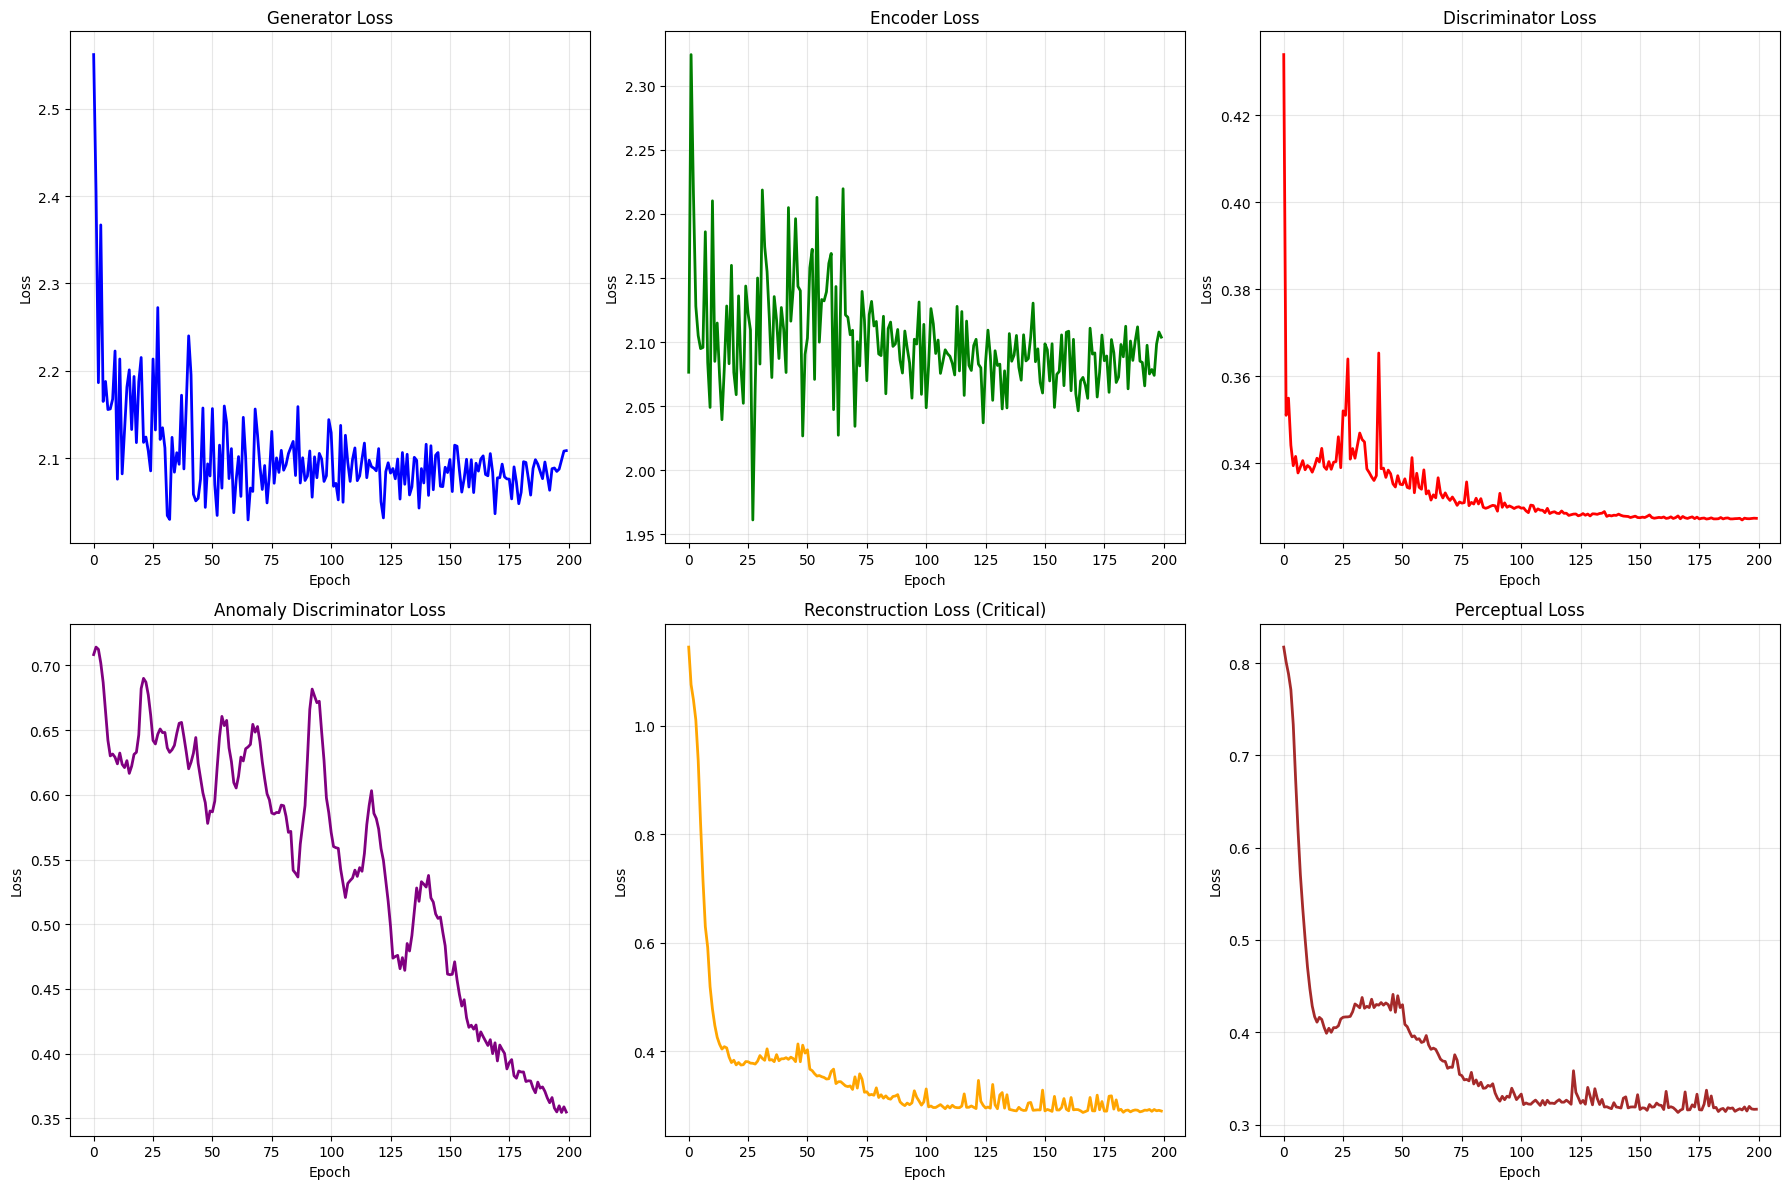

🎨 Generating optimized normal data samples...
   🔍 Applying quality filter (from 717 to 552)...
   ✅ Selected 552 highest quality samples
✅ Generated 552 high-quality normal samples
📊 Generated data statistics:
   Shape: (552, 4500, 14)
   Mean: 0.006450
   Std: 0.390293
   Range: [-1.085765, 1.089827]
💾 Storing optimized generated data for enhanced anomaly detection...


In [4]:
# ========================================
# OPTIMIZED BIGAN TRAINING FOR NORMAL DATA GENERATION
# ========================================

# Clear GPU memory first
torch.cuda.empty_cache()

# Enhanced preprocessing with robust normalization
normal_data_normalized, data_scaler = preprocess_data(X_train_normal, fit_scaler=True)

# Optimized training parameters for better normal data generation
latent_dim = 64
epochs = 200  # More epochs for better convergence
batch_size = 32  # Increased batch size for stability
save_interval = 20

print("🚀 OPTIMIZED BIGAN TRAINING FOR ANOMALY DETECTION")
print("=" * 60)
print(f"📊 Training Configuration:")
print(f"   Data shape: {normal_data_normalized.shape}")
print(f"   Latent dimension: {latent_dim}")
print(f"   Batch size: {batch_size}")
print(f"   Epochs: {epochs}")

# Enhanced data loading with data augmentation
class AugmentedDataset(Dataset):
    def __init__(self, data, augment_prob=0.3):
        # Convert from (samples, seq_len, channels) to (samples, channels, seq_len)
        self.data = torch.tensor(data.transpose(0, 2, 1), dtype=torch.float32)
        self.augment_prob = augment_prob
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sample = self.data[idx]
        
        # Simple data augmentation for time series
        if torch.rand(1) < self.augment_prob:
            # Add small amount of noise
            noise = torch.randn_like(sample) * 0.01
            sample = sample + noise
            
            # Random scaling
            scale = torch.rand(sample.size(0), 1) * 0.1 + 0.95  # Range [0.95, 1.05]
            sample = sample * scale
        
        return sample, 0

# Create enhanced dataset
dataset = AugmentedDataset(normal_data_normalized, augment_prob=0.2)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

# Initialize BiGAN with improved architecture
bigan = AnomalyAwareBiGAN(latent_dim=latent_dim, channels=14, seq_len=4500).to(device)

# Check model size
total_params = sum(p.numel() for p in bigan.parameters())
print(f"🔧 Model parameters: {total_params:,}")

# Optimized optimizers with different learning rates and schedules
optimizer_G = optim.Adam(bigan.generator.parameters(), lr=0.0001, betas=(0.5, 0.999), weight_decay=1e-5)
optimizer_E = optim.Adam(bigan.encoder.parameters(), lr=0.0001, betas=(0.5, 0.999), weight_decay=1e-5)
optimizer_D = optim.Adam(bigan.discriminator.parameters(), lr=0.00005, betas=(0.5, 0.999), weight_decay=1e-5)  # Slower discriminator
optimizer_A = optim.Adam(bigan.anomaly_discriminator.parameters(), lr=0.00005, betas=(0.5, 0.999), weight_decay=1e-5)

# Learning rate schedulers for adaptive training
scheduler_G = optim.lr_scheduler.CosineAnnealingLR(optimizer_G, T_max=epochs, eta_min=1e-6)
scheduler_E = optim.lr_scheduler.CosineAnnealingLR(optimizer_E, T_max=epochs, eta_min=1e-6)
scheduler_D = optim.lr_scheduler.CosineAnnealingLR(optimizer_D, T_max=epochs, eta_min=1e-6)

# Enhanced loss functions
adversarial_loss = nn.BCELoss()
reconstruction_loss = nn.MSELoss()
perceptual_loss = nn.L1Loss()

# Training tracking
training_history = {
    'g_losses': [], 'e_losses': [], 'd_losses': [], 'a_losses': [], 
    'recon_losses': [], 'perceptual_losses': []
}

# Advanced training loop with focus on quality
print("📈 Starting optimized training...")

for epoch in range(epochs):
    epoch_losses = {'g': 0, 'e': 0, 'd': 0, 'a': 0, 'recon': 0, 'perceptual': 0}
    
    for i, (real_samples, _) in enumerate(dataloader):
        real_samples = real_samples.to(device)
        batch_size_current = real_samples.size(0)
        
        # Enhanced label smoothing
        real_labels = torch.ones(batch_size_current, 1, device=device) * 0.9
        fake_labels = torch.zeros(batch_size_current, 1, device=device) + 0.1
        
        # Generate random latent vectors
        z = torch.randn(batch_size_current, latent_dim, device=device)
        
        # ---------------------
        #  Train Discriminator (Less Frequently for Better Balance)
        # ---------------------
        if i % 2 == 0:  # Train discriminator every other iteration
            optimizer_D.zero_grad()
            
            # Real data with encoded latent
            with torch.no_grad():
                encoded_z = bigan.encoder(real_samples)
            real_validity = bigan.discriminator(real_samples, encoded_z)
            d_real_loss = adversarial_loss(real_validity, real_labels)
            
            # Fake data with random latent
            with torch.no_grad():
                fake_samples = bigan.generator(z)
            fake_validity = bigan.discriminator(fake_samples, z)
            d_fake_loss = adversarial_loss(fake_validity, fake_labels)
            
            d_loss = (d_real_loss + d_fake_loss) / 2
            d_loss.backward()
            
            torch.nn.utils.clip_grad_norm_(bigan.discriminator.parameters(), max_norm=0.5)
            optimizer_D.step()
            
            epoch_losses['d'] += d_loss.item()
        
        # ---------------------
        #  Train Anomaly Discriminator (Even Less Frequently)
        # ---------------------
        if i % 3 == 0:
            optimizer_A.zero_grad()
            
            encoded_z = bigan.encoder(real_samples)
            anomaly_real = bigan.anomaly_discriminator(encoded_z.detach())
            anomaly_fake = bigan.anomaly_discriminator(z)
            
            a_real_loss = adversarial_loss(anomaly_real, real_labels)
            a_fake_loss = adversarial_loss(anomaly_fake, fake_labels)
            a_loss = (a_real_loss + a_fake_loss) / 2
            
            a_loss.backward()
            torch.nn.utils.clip_grad_norm_(bigan.anomaly_discriminator.parameters(), max_norm=0.5)
            optimizer_A.step()
            
            epoch_losses['a'] += a_loss.item()
        
        # ---------------------
        #  Train Generator and Encoder (Focus on Quality)
        # ---------------------
        optimizer_G.zero_grad()
        optimizer_E.zero_grad()
        
        # Generate samples and encode real data
        fake_samples = bigan.generator(z)
        encoded_z = bigan.encoder(real_samples)
        
        # Adversarial losses
        g_validity = bigan.discriminator(fake_samples, z)
        g_loss = adversarial_loss(g_validity, real_labels)
        
        e_validity = bigan.discriminator(real_samples, encoded_z)
        e_loss = adversarial_loss(e_validity, fake_labels)
        
        # CRITICAL: Enhanced reconstruction loss for normal data quality
        reconstructed = bigan.generator(encoded_z)
        recon_loss = reconstruction_loss(reconstructed, real_samples)
        
        # Perceptual loss (feature-level similarity)
        perceptual_recon_loss = perceptual_loss(reconstructed, real_samples)
        
        # Anomaly-aware loss
        anomaly_encoder_loss = adversarial_loss(
            bigan.anomaly_discriminator(encoded_z), fake_labels
        )
        
        # Enhanced loss combination with higher emphasis on reconstruction quality
        reconstruction_weight = 1.0  # Increased weight for better normal data quality
        perceptual_weight = 0.5      # Additional perceptual similarity
        anomaly_weight = 0.1
        
        total_ge_loss = (g_loss + e_loss + 
                        reconstruction_weight * recon_loss +
                        perceptual_weight * perceptual_recon_loss +
                        anomaly_weight * anomaly_encoder_loss)
        
        total_ge_loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(bigan.generator.parameters(), max_norm=0.5)
        torch.nn.utils.clip_grad_norm_(bigan.encoder.parameters(), max_norm=0.5)
        
        optimizer_G.step()
        optimizer_E.step()
        
        # Record losses
        epoch_losses['g'] += g_loss.item()
        epoch_losses['e'] += e_loss.item()
        epoch_losses['recon'] += recon_loss.item()
        epoch_losses['perceptual'] += perceptual_recon_loss.item()
        
        # Memory management
        if i % 10 == 0:
            torch.cuda.empty_cache()
    
    # Update learning rates
    scheduler_G.step()
    scheduler_E.step()
    scheduler_D.step()
    
    # Calculate average losses
    num_batches = len(dataloader)
    avg_losses = {
        'g': epoch_losses['g'] / num_batches,
        'e': epoch_losses['e'] / num_batches,
        'd': epoch_losses['d'] / max(1, num_batches // 2),
        'a': epoch_losses['a'] / max(1, num_batches // 3),
        'recon': epoch_losses['recon'] / num_batches,
        'perceptual': epoch_losses['perceptual'] / num_batches
    }
    
    # Store training history
    training_history['g_losses'].append(avg_losses['g'])
    training_history['e_losses'].append(avg_losses['e'])
    training_history['d_losses'].append(avg_losses['d'])
    training_history['a_losses'].append(avg_losses['a'])
    training_history['recon_losses'].append(avg_losses['recon'])
    training_history['perceptual_losses'].append(avg_losses['perceptual'])
    
    # Enhanced progress reporting
    if (epoch + 1) % save_interval == 0 or epoch == epochs - 1:
        print(f"Epoch {epoch+1:3d}/{epochs} | "
              f"G: {avg_losses['g']:.4f} | E: {avg_losses['e']:.4f} | "
              f"D: {avg_losses['d']:.4f} | A: {avg_losses['a']:.4f} | "
              f"Recon: {avg_losses['recon']:.4f} | Perc: {avg_losses['perceptual']:.4f}")
        
        # Quality assessment
        with torch.no_grad():
            test_z = torch.randn(4, latent_dim, device=device)
            test_samples = bigan.generator(test_z)
            sample_std = torch.std(test_samples).item()
            sample_mean = torch.mean(test_samples).item()
            print(f"         Sample stats: μ={sample_mean:.4f}, σ={sample_std:.4f}")
    
    # Early stopping based on reconstruction quality
    if len(training_history['recon_losses']) > 30:
        recent_recon = training_history['recon_losses'][-15:]
        if max(recent_recon) - min(recent_recon) < 1e-6:
            print(f"🛑 Early stopping at epoch {epoch+1} - reconstruction converged")
            break

print("✅ Optimized BiGAN training completed!")

# Enhanced visualization of training progress
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Individual loss plots
losses_to_plot = [
    ('g_losses', 'Generator Loss', 'blue'),
    ('e_losses', 'Encoder Loss', 'green'),
    ('d_losses', 'Discriminator Loss', 'red'),
    ('a_losses', 'Anomaly Discriminator Loss', 'purple'),
    ('recon_losses', 'Reconstruction Loss (Critical)', 'orange'),
    ('perceptual_losses', 'Perceptual Loss', 'brown')
]

for idx, (loss_key, title, color) in enumerate(losses_to_plot):
    row, col = idx // 3, idx % 3
    axes[row, col].plot(training_history[loss_key], color=color, linewidth=2)
    axes[row, col].set_title(title)
    axes[row, col].set_xlabel('Epoch')
    axes[row, col].set_ylabel('Loss')
    axes[row, col].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Generate high-quality samples for anomaly detection
print("🎨 Generating optimized normal data samples...")

def generate_enhanced_bigan_samples(bigan, num_samples, data_scaler, latent_dim=64, quality_filter=True):
    """
    Generate high-quality samples with optional quality filtering
    """
    device = next(bigan.parameters()).device
    bigan.eval()
    
    # Generate more samples than needed for quality filtering
    samples_to_generate = int(num_samples * 1.3) if quality_filter else num_samples
    batch_size = 16
    all_samples = []
    
    with torch.no_grad():
        for start in range(0, samples_to_generate, batch_size):
            end = min(start + batch_size, samples_to_generate)
            current_batch_size = end - start
            
            # Use controlled latent sampling for better quality
            z = torch.randn(current_batch_size, latent_dim, device=device) * 0.8  # Reduce variance
            batch_samples = bigan.generator(z)
            all_samples.append(batch_samples.cpu())
            
            torch.cuda.empty_cache()
    
    generated_tensor = torch.cat(all_samples, dim=0)
    generated_data = generated_tensor.numpy().transpose(0, 2, 1)  # Convert to (n_samples, 4500, 14)
    
    # Quality filtering based on statistical properties
    if quality_filter and len(generated_data) > num_samples:
        print(f"   🔍 Applying quality filter (from {len(generated_data)} to {num_samples})...")
        
        # Calculate quality scores based on similarity to real normal data
        quality_scores = []
        for sample in generated_data:
            # Simple quality metric: distance from normal data statistics
            sample_mean = np.mean(sample)
            sample_std = np.std(sample)
            real_mean = np.mean(normal_data_normalized)
            real_std = np.std(normal_data_normalized)
            
            mean_diff = abs(sample_mean - real_mean) / (real_std + 1e-8)
            std_diff = abs(sample_std - real_std) / (real_std + 1e-8)
            quality_score = 1 / (1 + mean_diff + std_diff)
            quality_scores.append(quality_score)
        
        # Select top quality samples
        quality_indices = np.argsort(quality_scores)[-num_samples:]
        generated_data = generated_data[quality_indices]
        print(f"   ✅ Selected {len(generated_data)} highest quality samples")
    
    # Denormalize to original scale
    generated_data_denorm = denormalize_data(generated_data, data_scaler)
    
    return generated_data_denorm

# Generate enhanced samples
num_samples = len(X_train_normal)
generated_data = generate_enhanced_bigan_samples(
    bigan, 
    num_samples=num_samples, 
    data_scaler=data_scaler, 
    latent_dim=latent_dim,
    quality_filter=True
)

print(f"✅ Generated {len(generated_data)} high-quality normal samples")
print(f"📊 Generated data statistics:")
print(f"   Shape: {generated_data.shape}")
print(f"   Mean: {generated_data.mean():.6f}")
print(f"   Std: {generated_data.std():.6f}")
print(f"   Range: [{generated_data.min():.6f}, {generated_data.max():.6f}]")

# Store the optimized generated data
print("💾 Storing optimized generated data for enhanced anomaly detection...")


🔍 Assessing BiGAN Generated Normal Data Quality...

🔍 BiGAN Generated Normal Data Assessment
📊 Statistical Comparison:
   Real Data Shape: (552, 4500, 14)
   Generated Data Shape: (552, 4500, 14)
   Real Mean: 0.013143, Std: 0.991953
   Generated Mean: 0.006450, Std: 0.390293
   Mean Difference: 0.006693
   Std Difference: 0.601660

🧪 Statistical Tests:
   KS Test: statistic=0.3991, p-value=0.000000
   KS Interpretation: ⚠️ Different distributions


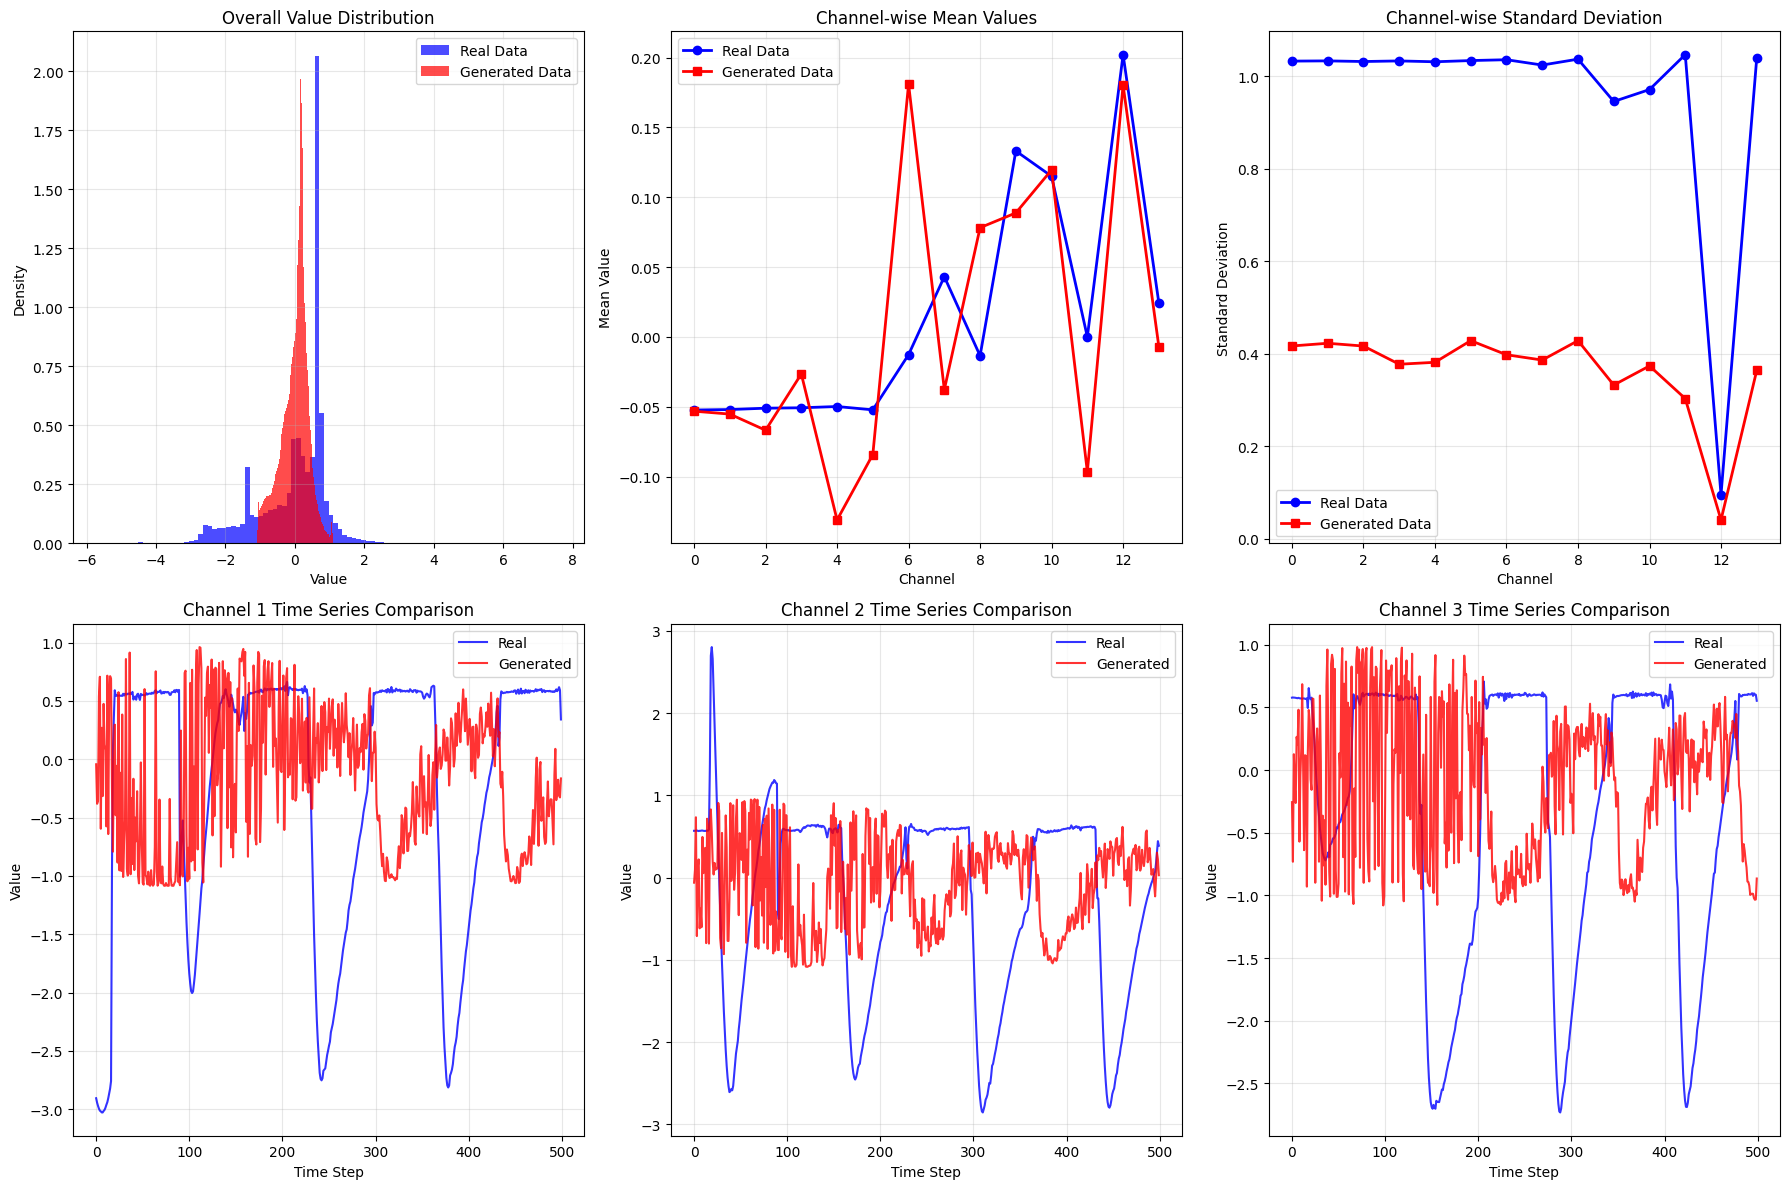


🎯 Data Quality Score: 0.6934 (0=Poor, 1=Perfect)
   🔄 Good quality - Generated data reasonably similar to real data

💾 Quality metrics stored for further analysis


In [5]:
# ========================================
# DATA QUALITY ASSESSMENT FOR GENERATED NORMAL SAMPLES
# ========================================

def assess_generated_data_quality(real_data, generated_data, title="Data Quality Assessment"):
    """
    Comprehensive assessment of generated data quality for anomaly detection
    """
    print(f"\n{'='*60}")
    print(f"🔍 {title}")
    print(f"{'='*60}")
    
    # Basic statistics comparison
    print("📊 Statistical Comparison:")
    print(f"   Real Data Shape: {real_data.shape}")
    print(f"   Generated Data Shape: {generated_data.shape}")
    print(f"   Real Mean: {real_data.mean():.6f}, Std: {real_data.std():.6f}")
    print(f"   Generated Mean: {generated_data.mean():.6f}, Std: {generated_data.std():.6f}")
    print(f"   Mean Difference: {abs(real_data.mean() - generated_data.mean()):.6f}")
    print(f"   Std Difference: {abs(real_data.std() - generated_data.std()):.6f}")
    
    # Distribution comparison using statistical tests
    from scipy import stats
    
    # Flatten data for statistical tests
    real_flat = real_data.reshape(-1)
    gen_flat = generated_data.reshape(-1)
    
    # Kolmogorov-Smirnov test
    ks_stat, ks_p = stats.ks_2samp(real_flat, gen_flat)
    print(f"\n🧪 Statistical Tests:")
    print(f"   KS Test: statistic={ks_stat:.4f}, p-value={ks_p:.6f}")
    print(f"   KS Interpretation: {'✅ Similar distributions' if ks_p > 0.05 else '⚠️ Different distributions'}")
    
    # Visualizations
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # 1. Overall distribution comparison
    axes[0, 0].hist(real_flat, bins=100, alpha=0.7, label='Real Data', color='blue', density=True)
    axes[0, 0].hist(gen_flat, bins=100, alpha=0.7, label='Generated Data', color='red', density=True)
    axes[0, 0].set_title('Overall Value Distribution')
    axes[0, 0].set_xlabel('Value')
    axes[0, 0].set_ylabel('Density')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Channel-wise mean comparison
    real_channel_means = real_data.mean(axis=1).mean(axis=0)  # Mean across time and samples
    gen_channel_means = generated_data.mean(axis=1).mean(axis=0)
    
    x_channels = range(len(real_channel_means))
    axes[0, 1].plot(x_channels, real_channel_means, 'o-', label='Real Data', color='blue', linewidth=2)
    axes[0, 1].plot(x_channels, gen_channel_means, 's-', label='Generated Data', color='red', linewidth=2)
    axes[0, 1].set_title('Channel-wise Mean Values')
    axes[0, 1].set_xlabel('Channel')
    axes[0, 1].set_ylabel('Mean Value')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Channel-wise standard deviation comparison
    real_channel_stds = real_data.std(axis=1).mean(axis=0)
    gen_channel_stds = generated_data.std(axis=1).mean(axis=0)
    
    axes[0, 2].plot(x_channels, real_channel_stds, 'o-', label='Real Data', color='blue', linewidth=2)
    axes[0, 2].plot(x_channels, gen_channel_stds, 's-', label='Generated Data', color='red', linewidth=2)
    axes[0, 2].set_title('Channel-wise Standard Deviation')
    axes[0, 2].set_xlabel('Channel')
    axes[0, 2].set_ylabel('Standard Deviation')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    
    # 4. Sample time series comparison (first 3 channels)
    sample_idx = np.random.randint(0, min(real_data.shape[0], generated_data.shape[0]))
    time_steps = range(min(500, real_data.shape[1]))  # Show first 500 time steps
    
    for ch in range(min(3, real_data.shape[2])):
        axes[1, ch].plot(time_steps, real_data[sample_idx, :len(time_steps), ch], 
                        label='Real', color='blue', alpha=0.8)
        axes[1, ch].plot(time_steps, generated_data[sample_idx, :len(time_steps), ch], 
                        label='Generated', color='red', alpha=0.8)
        axes[1, ch].set_title(f'Channel {ch+1} Time Series Comparison')
        axes[1, ch].set_xlabel('Time Step')
        axes[1, ch].set_ylabel('Value')
        axes[1, ch].legend()
        axes[1, ch].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Quality score calculation
    mean_diff_norm = abs(real_data.mean() - generated_data.mean()) / (real_data.std() + 1e-8)
    std_diff_norm = abs(real_data.std() - generated_data.std()) / (real_data.std() + 1e-8)
    
    quality_score = max(0, 1 - (mean_diff_norm + std_diff_norm) / 2)
    
    print(f"\n🎯 Data Quality Score: {quality_score:.4f} (0=Poor, 1=Perfect)")
    if quality_score > 0.8:
        print("   ✅ Excellent quality - Generated data very similar to real data")
    elif quality_score > 0.6:
        print("   🔄 Good quality - Generated data reasonably similar to real data")
    elif quality_score > 0.4:
        print("   ⚠️ Moderate quality - Some differences in data distributions")
    else:
        print("   ❌ Poor quality - Significant differences in data distributions")
    
    return quality_score

# Assess the quality of your generated data
print("🔍 Assessing BiGAN Generated Normal Data Quality...")
quality_score = assess_generated_data_quality(
    real_data=normal_data[:len(generated_data)],  # Use same number of samples for comparison
    generated_data=generated_data,
    title="BiGAN Generated Normal Data Assessment"
)

# Store quality metrics
quality_metrics = {
    'overall_quality_score': quality_score,
    'real_data_stats': {
        'mean': normal_data.mean(),
        'std': normal_data.std(),
        'shape': normal_data.shape
    },
    'generated_data_stats': {
        'mean': generated_data.mean(),
        'std': generated_data.std(),
        'shape': generated_data.shape
    }
}

print(f"\n💾 Quality metrics stored for further analysis")

In [6]:
# ===============================
# FID SCORE EVALUATION
# ===============================

# Test the simplified FID calculation
print("Testing simplified FID calculation...")

# Use smaller subsets for testing
test_real = X_train_normal[:100]  # Use 100 samples for testing
test_generated = generated_data[:100]

print(f"Test real data shape: {test_real.shape}")
print(f"Test generated data shape: {test_generated.shape}")

# Calculate FID score
fid_score = calculate_fid_score(
    real_data=test_real,
    fake_data=test_generated,
    device=device,
    sample_rate=1000,
)

if fid_score is not None:
    print(f"\n🎉 SUCCESS! FID Score: {fid_score:.4f}")
    
    # Interpret the score
    if fid_score < 10:
        quality = "Excellent"
    elif fid_score < 25:
        quality = "Good"
    elif fid_score < 50:
        quality = "Fair"
    elif fid_score < 100:
        quality = "Poor"
    else:
        quality = "Very Poor"
    
    print(f"Quality Assessment: {quality}")
else:
    print("❌ FID calculation failed. Please check the error messages above.")

Testing simplified FID calculation...
Test real data shape: (100, 4500, 14)
Test generated data shape: (100, 4500, 14)
Processing real data for FID...
Processing 100 samples for FID calculation (299x299)...
Processed 0/100 samples
Processing fake data for FID...
Processing 100 samples for FID calculation (299x299)...
Processed 0/100 samples
Calculating FID with 100 samples each...
Real images shape: torch.Size([100, 3, 299, 299])
Fake images shape: torch.Size([100, 3, 299, 299])
Real images range: [0.0000, 0.9816]
Fake images range: [0.0000, 0.9973]
After clamping - Real images range: [0.0000, 0.9816]
After clamping - Fake images range: [0.0000, 0.9973]
FID Score: 29.1522

🎉 SUCCESS! FID Score: 29.1522
Quality Assessment: Fair



COMPREHENSIVE ANOMALY DETECTION CROSS-VALIDATION EXPERIMENT
Normal samples: 138
Faulty samples: 37
Generated samples: 552 (GAN Type: aabigan)
Cross-validation folds: 5

========================= FOLD 1/5 =========================
Fold 1 - Train normal: 110
Fold 1 - Train faulty: 30
Fold 1 - Test: 35 (28 normal, 7 faulty)
Processing data through feature extraction...
Processing 30 samples with multi-channel approach...
Processing 35 samples with multi-channel approach...
Processing 110 samples with multi-channel approach...
Training baseline autoencoder (without GAN)...
Fold 1 - Augmented normal data: 662 samples
Processing 662 samples with multi-channel approach...
Training GAN-augmented autoencoder...

Fold 1 Results Comparison:
--------------------------------------------------------------------------------
Method             | Metric   | Baseline   | GAN-Aug    | Improvement 
--------------------------------------------------------------------------------
F1_Threshold       | accur

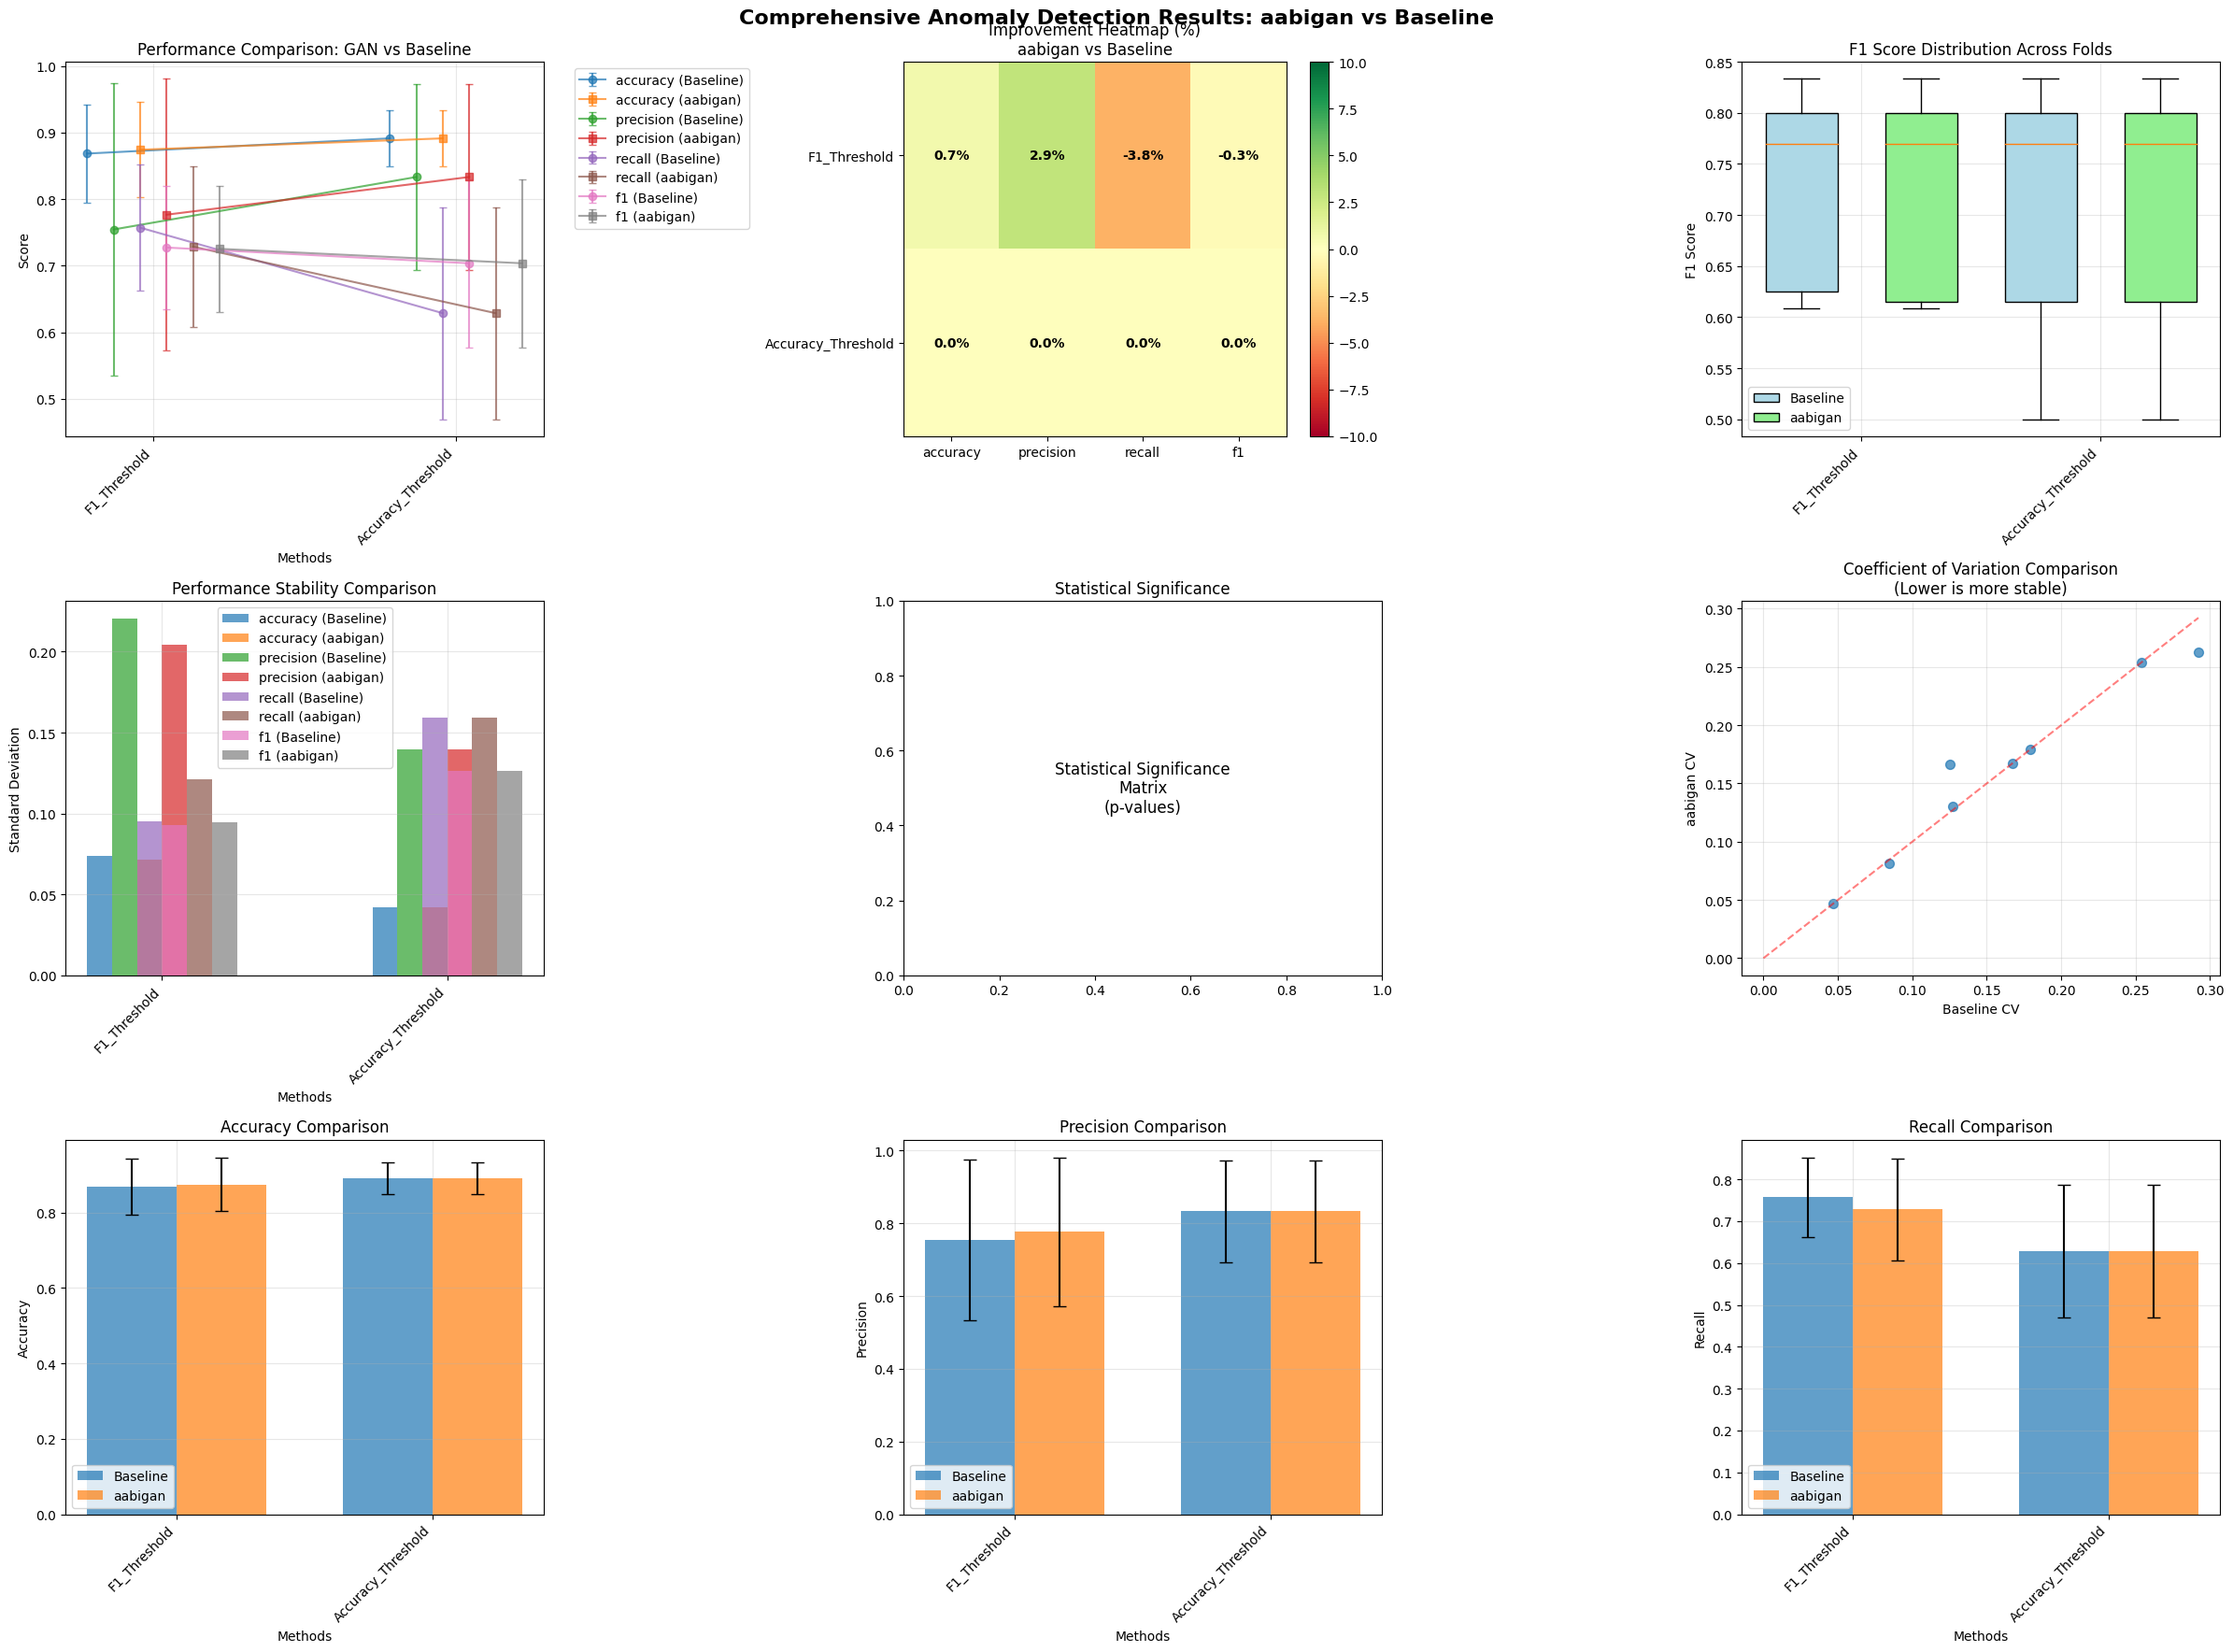


ENHANCED ANOMALY DETECTION RECOMMENDATIONS (aabigan)

🏆 BEST METHODS WITH aabigan:
   • Best F1 Score: F1_Threshold (0.7253 ± 0.0947)
   • Most Stable: F1_Threshold (CV = 0.1306)

📈 aabigan EFFECTIVENESS:
   • F1_Threshold: 50% metrics improved, 0% significantly
   • Accuracy_Threshold: 0% metrics improved, 0% significantly

🎯 aabigan OVERALL EFFECTIVENESS: Not Effective
   • 0/8 comparisons show significant improvement
   • Success Rate: 0.0%

📊 METHOD-SPECIFIC INSIGHTS:
   • F1_Threshold          : No Significant Benefit
   • Accuracy_Threshold    : No Significant Benefit

🎯 FINAL RECOMMENDATIONS:
   ❌ aabigan data augmentation shows LIMITED benefit
   • Consider baseline methods or alternative GAN architectures
   • Current success rate: 0.0%

💡 DEPLOYMENT STRATEGY:
   • Stick with baseline methods for now
   • Investigate alternative data augmentation strategies
   • Consider ensemble methods combining multiple approaches



({'F1_Threshold': {'accuracy': {'mean': 0.8742857142857143,
    'std': 0.07137140569598167,
    'min': 0.7428571428571429,
    'max': 0.9428571428571428,
    'median': 0.9142857142857143,
    'values': [0.9142857142857143,
     0.8571428571428571,
     0.9428571428571428,
     0.9142857142857143,
     0.7428571428571429]},
   'precision': {'mean': 0.7766666666666666,
    'std': 0.20428737928059415,
    'min': 0.4666666666666667,
    'max': 1.0,
    'median': 0.75,
    'values': [0.75, 0.6666666666666666, 1.0, 1.0, 0.4666666666666667]},
   'recall': {'mean': 0.7285714285714285,
    'std': 0.12132348393902163,
    'min': 0.5714285714285714,
    'max': 0.875,
    'median': 0.7142857142857143,
    'values': [0.8571428571428571,
     0.5714285714285714,
     0.7142857142857143,
     0.625,
     0.875]},
   'f1': {'mean': 0.7253288740245262,
    'std': 0.09471976048836564,
    'min': 0.608695652173913,
    'max': 0.8333333333333333,
    'median': 0.7692307692307693,
    'values': [0.79999999

In [7]:
run_comprehensive_cross_validation_experiment(X_test_normal, X_test_faulty, device, generated_data, batch_size=32, gan_type="aabigan")